In [3]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from util.data_loader import load_dataset, split_train_validation, custom_random_oversampling, create_csv_submission
from util.features_util import keep_features
from util.features_info import FEATURES_DICT, REPLACEMENT_LIST
from util.preprocessing import preprocessing_pipeline
from util.train import reg_logistic_regression
from util.plotting import loss_visualization
from util.evaluation import evaluation_summary
from util.predict import predict, predict_no_labels


BASE_PATH = os.path.dirname(os.getcwd()) + "/data"

# Data loading

### ⚠️ Note that the `x_sub` here refers to data for which predictions will be made, but for which we don't have the labels! To refer to the data used for local testing we'll use `x_va` and `y_va` (validation).

In [4]:
# Load data without subsampling
x_train, y_train, x_sub, feature_names = load_dataset(path_x_train=BASE_PATH + "/x_train.csv",
                                                      path_y_train=BASE_PATH + "/y_train.csv",
                                                      path_x_test=BASE_PATH + "/x_test.csv",
                                                      sub_sample=False)
# Create the feature index dictionary
feature_indexes = dict(zip(feature_names, range(len(feature_names))))

# Pre processing

In [5]:
# Keeping only selected features both in train and validation set
x_train_clean, clean_features, clean_feature_index = keep_features(x_train, FEATURES_DICT.keys(), feature_names, feature_indexes)

Kept 76 features: dict_keys(['GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', '_HCVU651', '_CHOLCHK', '_RFCHOL', 'CVDSTRK3', '_ASTHMS1', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', '_DRDXAR1', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'DIABAGE2', 'SEX', '_AGE80', 'MARITAL', '_CHLDCNT', '_EDUCAG', '_INCOMG', 'PREGNANT', 'QLACTLM2', 'USEEQUIP', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'HTM4', 'WTKG3', '_BMI5', '_SMOKER3', 'USENOW3', 'DRNKANY5', 'DROCDY3_', '_RFBING5', '_DRNKWEK', '_RFDRHV5', 'FTJUDA1_', 'FRUTDA1_', 'BEANDAY_', 'GRENDAY_', 'ORNGDAY_', 'VEGEDA1_', '_FRUTSUM', '_VEGESUM', '_FRTLT1', '_VEGLT1', '_TOTINDA', 'METVL11_', 'METVL21_', 'MAXVO2_', 'ACTIN11_', 'ACTIN21_', 'PADUR1_', 'PADUR2_', 'PAFREQ1_', 'PAFREQ2_', '_MINAC11', '_MINAC21', 'STRFREQ_', 'PA1MIN_', 'PAVIG11_', 'PAVIG21_', 'PA1VIGM_', '_PACAT1', '_PAINDX1', '_PA150R2', '_PA300R2', '_PA30021', '_PASTRNG'])


In [6]:
# Call to the preprocessing pipeline both for train and test set
# NOTE: the preprocessing automatically performs also normalization

x_train_preprocessed = preprocessing_pipeline(x_train_clean, 
                                              where=clean_features,
                                              feature_index=clean_feature_index,
                                              nan_replacement=REPLACEMENT_LIST)

## Split local data into train and validation

#### From now on we'll use the local train and validation data: `x_tr` and `y_tr` for training and `x_va` and `y_va` for validation

In [7]:
# Split local data into train and validation
(x_tr, x_va, y_tr, y_va) = split_train_validation(x_train_preprocessed,
                                                  y_train,
                                                  valid_proportion=0.2)

## Data preparation for training

In [8]:
# Perform over sampling (due to unbalanced data)
x_tr_oversampled, y_tr_oversampled = custom_random_oversampling(x_tr, y_tr[:,1])

# NOTE: to properly validate the model we should not oversample the validation set!
# x_va_oversampled, y_va_oversampled = custom_random_oversampling(x_va, y_va[:,1])


# Add bias column to the training and validation data
x_tr_oversampled_bias = np.append(x_tr_oversampled, np.ones(shape=(x_tr_oversampled.shape[0], 1)), axis=1)
x_va_bias = np.append(x_va, np.ones(shape=(x_va.shape[0], 1)), axis=1)


# Training

In [11]:
w, train_loss, valid_loss = reg_logistic_regression(x_tr_oversampled_bias,
                                                    y_tr_oversampled,
                                                    x_va_bias,
                                                    y_va[:, 1],
                                                    lambda_=0.0001, 
                                                    max_iter=5000,
                                                    gamma=0.001,
                                                    batch_size=100, 
                                                    w=np.random.random(size=x_tr_oversampled_bias.shape[1]),
                                                    all_losses=True)


Iteration 0/5000
Iteration 200/5000
Iteration 400/5000
Iteration 600/5000
Iteration 800/5000
Iteration 1000/5000
Iteration 1200/5000
Iteration 1400/5000
Iteration 1600/5000
Iteration 1800/5000
Iteration 2000/5000
Iteration 2200/5000
Iteration 2400/5000
Iteration 2600/5000
Iteration 2800/5000
Iteration 3000/5000
Iteration 3200/5000
Iteration 3400/5000
Iteration 3600/5000
Iteration 3800/5000
Iteration 4000/5000
Iteration 4200/5000
Iteration 4400/5000
Iteration 4600/5000
Iteration 4800/5000


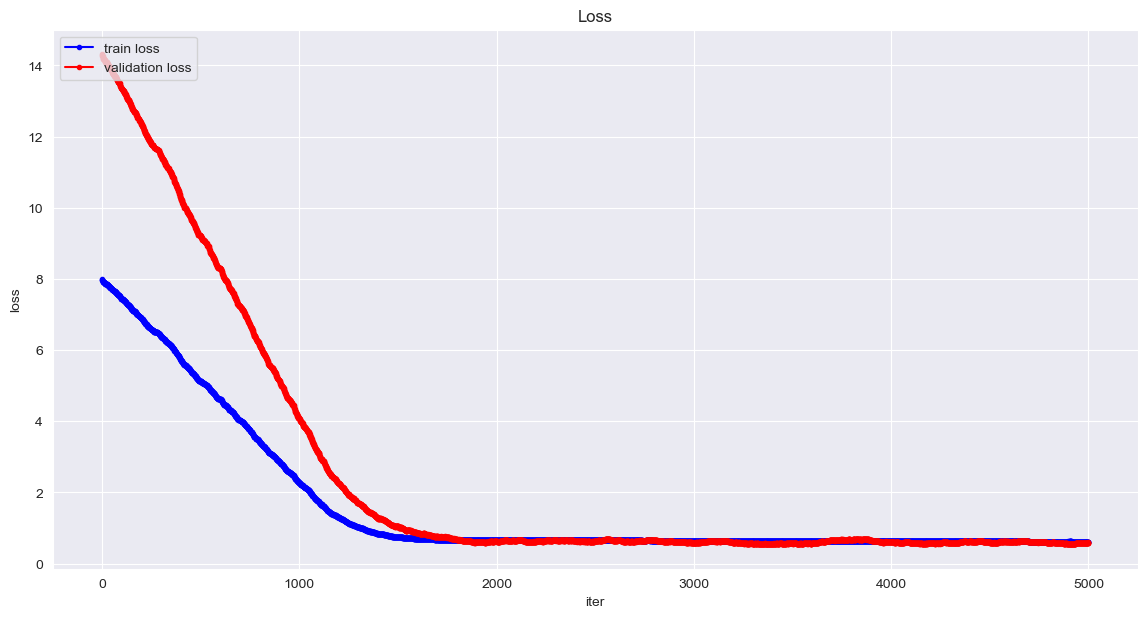

In [12]:
# plot losses
loss_visualization(train_loss, valid_loss)
#plt.yscale("log")

# Evaluation on training set

In [13]:
predicted_y_tr = predict(x_tr_oversampled_bias,
                         w,
                         threshold=0.5,
                         negative_label=-1)

print("EVALUATION SUMMARY ON TRAINING SET")
evaluation_summary(y_tr_oversampled, predicted_y_tr)

EVALUATION SUMMARY ON TRAINING SET
Accuracy: 66.15%
Precision: 67.87%
Recall: 59.10%
F1-score: 63.18%


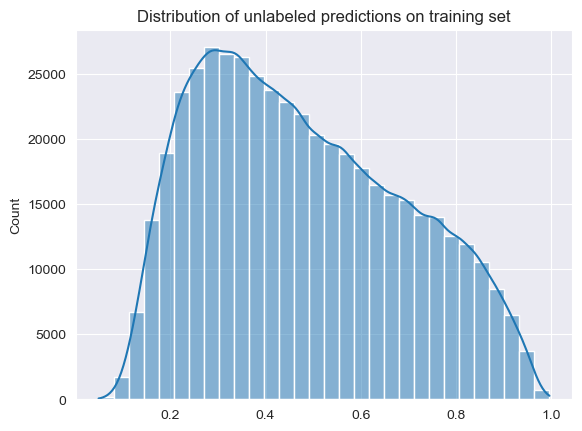

In [14]:
sns.histplot(predict_no_labels(x_tr_oversampled_bias, w), bins=30, kde=True)
plt.title("Distribution of unlabeled predictions on training set")
plt.show()

# Evaluation on validation set

In [18]:
predicted_y_va = predict(x_va_bias,
                         w,
                         threshold=0.5,
                         negative_label=-1)
print("EVALUATION SUMMARY ON VALIDATION SET")
evaluation_summary(y_va[:, 1], predicted_y_va)

EVALUATION SUMMARY ON VALIDATION SET
Accuracy: 71.51%
Precision: 17.40%
Recall: 58.77%
F1-score: 26.85%


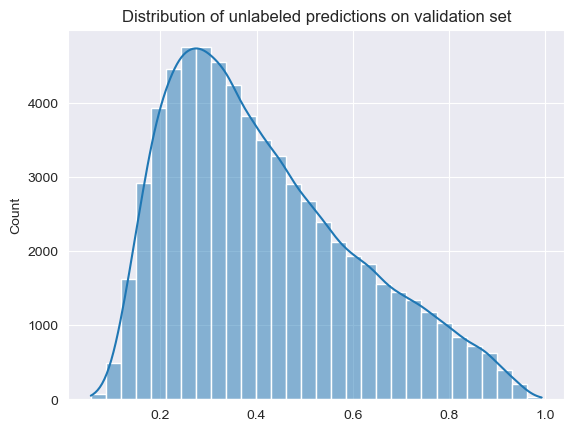

In [20]:
sns.histplot(predict_no_labels(x_va_bias, w), bins=30, kde=True)
plt.title("Distribution of unlabeled predictions on validation set")
plt.show()


---

# COMPUTE RESULT FOR SUBMISSION

## Pre processing and data preparation

In [ ]:
# Keep only selected features in submission data
x_sub_clean, clean_features, clean_feature_index = keep_features(x_sub, FEATURES_DICT.keys(), feature_names, feature_indexes)

x_sub_preprocessed = preprocessing_pipeline(x_sub_clean,
                                            where=clean_features,
                                            feature_index=clean_feature_index,
                                            nan_replacement=REPLACEMENT_LIST)

# Add bias column to the submission data
x_sub_bias = np.append(x_sub_preprocessed, np.ones(shape=(x_sub_preprocessed.shape[0], 1)), axis=1)

In [ ]:
predicted_y_sub = predict(x_sub_bias,
                          w,
                          threshold=0.5,
                          negative_label=-1)

sns.histplot(predict_no_labels(x_sub_bias, w), bins=30, kde=True)

In [ ]:
### Note: for the following we don't have true labels, so we can't compute the accuracy and other metrics

In [ ]:
# Save predictions to csv file

# FIXME: this is not working, we have to keep indexes!

create_csv_submission(ids=range(len(predicted_y_sub)), y_pred=predicted_y_sub, path=BASE_PATH + "/submission.csv")